In [1]:
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn


# class VAE(torch.nn.Module):
#     def __init__(self, input_dim, latent_dim, hidden_dim):
#         super(VAE, self).__init__()

#         # Encoder neural network
#         self.encoder = torch.nn.Sequential(
#             torch.nn.Linear(input_dim, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim, latent_dim * 2),  # *2 for mean and log-variance
#         )

#         # Decoder neural network
#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(latent_dim, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim, input_dim),
#         )

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         # Encode
#         mu_logvar = self.encoder(x)
#         mu, logvar = torch.chunk(
#             mu_logvar, 2, dim=1
#         )  # Split into mean and log-variance
#         z = self.reparameterize(mu, logvar)

#         # Decode
#         recon_x = self.decoder(z)

#         return recon_x, mu, logvar


def compute_elbo(x, vae):
    mu_logvar = vae.encoder(x)


    # Compute logqz
    logqz = -0.5 * torch.sum(
        eps**2 + torch.log(2 * torch.tensor([3.14])), dim=1
    ) - torch.sum(logvar, dim=1)

    # Compute logpz
    logpz = -0.5 * torch.sum(
        z**2 + torch.log(2 * torch.tensor([3.14])), dim=1
    )

    # Decode
    recon_x = vae.decoder(z)

    # Compute logpx
    logpx = torch.sum(
        x * torch.log(torch.sigmoid(recon_x))
        + (1 - x) * torch.log(1 - torch.sigmoid(recon_x)),
        dim=1,
    )

    # Compute ELBO
    elbo = logpx + logpz - logqz
    return elbo.mean()


# # Example usage
# input_dim = 784  # Input dimension (example MNIST image size)
# latent_dim = 2  # Latent dimension
# hidden_dim = 256  # Hidden layer dimension

# # Instantiate VAE model
# vae = VAE(input_dim, latent_dim, hidden_dim)

# # Example data
# x = torch.randn(64, input_dim)  # Example batch of data

# # Compute ELBO
# elbo = compute_elbo(x, vae)
# print("ELBO:", elbo.item())

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import math


class VAE(torch.nn.Module):
    def __init__(
        self,
        input_dim=784,
        latent_dim=16,
        hidden_dim1=512,
        hidden_dim2=256,
        hidden_dim3=64,
    ):
        super(VAE, self).__init__()
        mask = torch.tril(torch.ones(latent_dim, latent_dim))
        diag = torch.diag_embed(torch.ones(latent_dim))
        mask = mask - diag
        self.register_buffer("mask", mask.unsqueeze(0))

        # Encoder neural network
        self.encoder_hidden_1 = nn.Linear(input_dim, hidden_dim1)
        self.encoder_hidden_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.encoder_hidden_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.encoder_mean = nn.Linear(hidden_dim3, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim3, latent_dim)
        self.encoder_Lprime = nn.Linear(
            hidden_dim3, latent_dim * (latent_dim + 1) // 2
        )  # For L_prime

        # Decoder neural network
        self.decoder_hidden_1 = nn.Linear(latent_dim, hidden_dim3)
        self.decoder_hidden_2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.decoder_hidden_3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.decoder_output = nn.Linear(hidden_dim1, input_dim)

    def reparameterize(self, mu, L):
        eps = torch.randn_like(L)
        return torch.diag_embed(mu) + L * eps

    # @staticmethod
    # def lower_triangular_mask(latent_dim):
    #     mask = torch.tril(torch.ones(latent_dim, latent_dim))
    #     diag = torch.diag_embed(torch.ones(latent_dim))
    #     mask = mask - diag
    #     return mask.unsqueeze(0)  # Add a batch dimension

    # Function to convert Lprime to lower triangular matrix
    @staticmethod
    def Lprime_to_lower_triangular(Lprime, latent_dim):
        tril_indices = torch.tril_indices(row=latent_dim, col=latent_dim)
        L = torch.zeros(Lprime.shape[0], latent_dim, latent_dim)
        L[:, tril_indices[0], tril_indices[1]] = Lprime
        return L

    def forward(self, x):
        # Encode
        h = torch.relu(self.encoder_hidden_1(x))
        h = torch.relu(self.encoder_hidden_2(h))
        h = torch.relu(self.encoder_hidden_3(h))
        mu = self.encoder_mean(h)
        logvar = self.encoder_logvar(h)

        Lprime = self.encoder_Lprime(h)
        sigma = torch.exp(0.5 * logvar)

        # Convert Lprime to lower triangular matrix
        Lprime_ = self.Lprime_to_lower_triangular(Lprime, latent_dim)

        # Apply the mask and add the diagonal of sigma
        L = self.mask* Lprime_ + torch.diag_embed(sigma)

        # Reparameterize
        eps = torch.randn_like(mu)
        z = mu + torch.matmul(L, eps.unsqueeze(-1)).squeeze(-1)

        # Decode
        h = torch.relu(self.decoder_hidden_1(z))
        h = torch.relu(self.decoder_hidden_2(h))
        h = torch.relu(self.decoder_hidden_3(h))
        recon_x = self.decoder_output(h)

        return recon_x, mu, logvar, eps, z


def compute_elbo(x, vae):
    recon_x, mu, logvar, eps, z = vae(x)

    # Check for NaN values in logvar
    # if torch.isnan(logvar).any():
    #     print("NaN values detected in logvar before clamping:", logvar)

    # # Clamp logvar to prevent NaN values
    # logvar = torch.clamp(logvar, min=-10, max=10)

    # Compute logqz
    logqz = -0.5 * torch.sum(
        (eps**2) + torch.log(torch.tensor([2 * math.pi])) + (0.5 * logvar), dim=1
    )

    # Compute logpz
    logpz = -0.5 * torch.sum((z**2) + torch.log(torch.tensor([2 * math.pi])), dim=1)

    # Compute logpx
    # logpx = torch.sum(
    #     x * torch.log(torch.sigmoid(recon_x))
    #     + (1 - x) * torch.log(1 - torch.sigmoid(recon_x)),
    #     dim=1,
    # )

    # Compute ELBO
    bce_loss_with_logits = nn.BCEWithLogitsLoss(reduction="sum")
    logpx = -bce_loss_with_logits(recon_x, x)
    elbo = logpx + logpz - logqz
    return elbo.mean()


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./data", train=False, transform=transform)

# Define data loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)


# Training function
def train_vae(vae, train_loader, optimizer, epochs):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            elbo = compute_elbo(x.view(-1, input_dim), vae)
            loss = -elbo
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(
            "Epoch {}, Average Loss: {:.4f}".format(
                epoch + 1, total_loss / len(train_loader)
            )
        )


input_dim = 784  # MNIST image size 28x28=784
latent_dim = 16  # 16-dimensional latent space
hidden_dim1 = 512  # Hidden layer dimension
hidden_dim2 = 256  # Hidden layer dimension
hidden_dim3 = 64  # Hidden layer dimension

vae = VAE(input_dim, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3)

# Define optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

# Train VAE
epochs = 50
train_vae(vae, train_loader, optimizer, epochs)

/home/mayag88/mayag88/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Average Loss: 25673.3390
Epoch 2, Average Loss: 20428.3811
Epoch 3, Average Loss: 18864.8599
Epoch 4, Average Loss: 17784.6173
Epoch 5, Average Loss: 17304.0658
Epoch 6, Average Loss: 17093.1404
Epoch 7, Average Loss: 16932.7057
Epoch 8, Average Loss: 16851.2555
Epoch 9, Average Loss: 16789.5910
Epoch 10, Average Loss: 16713.8380
Epoch 11, Average Loss: 16666.5945
Epoch 12, Average Loss: 16666.1084
Epoch 13, Average Loss: 16604.8106
Epoch 14, Average Loss: 16582.8578
Epoch 15, Average Loss: 16600.5572
Epoch 16, Average Loss: 16565.1265
Epoch 17, Average Loss: 16545.9844
Epoch 18, Average Loss: 16505.5168
Epoch 19, Average Loss: 16520.2597
Epoch 20, Average Loss: 16531.2756
Epoch 21, Average Loss: 16480.9500
Epoch 22, Average Loss: 16472.6828
Epoch 23, Average Loss: 16502.6424
Epoch 24, Average Loss: 16467.2433
Epoch 25, Average Loss: 16464.8297
Epoch 26, Average Loss: 16455.3442
Epoch 27, Average Loss: 16442.5252
Epoch 28, Average Loss: 16434.7062
Epoch 29, Average Loss: 16448

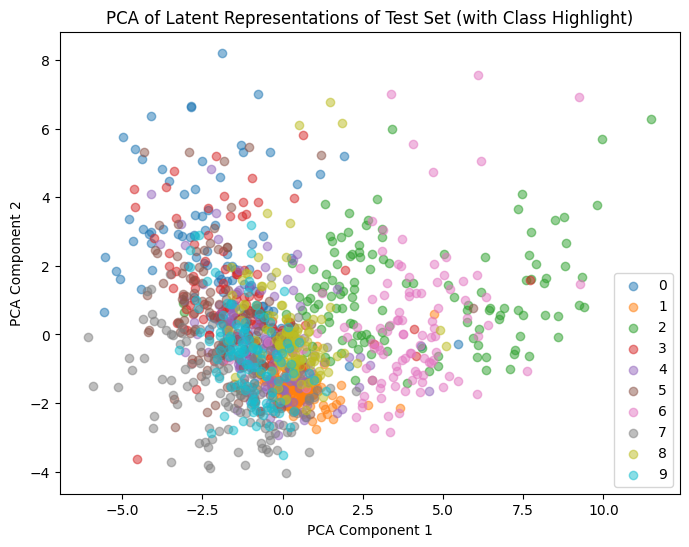

In [6]:
# Test VAE on test set
vae.eval()
with torch.no_grad():
    test_latents = []
    test_labels = []  # Store corresponding labels
    for x, labels in test_loader:  # Retrieve labels from test_loader
        recon_x, mu, logvar, eps, z = vae(x.view(-1, input_dim))
        test_latents.append(mu.numpy())
        test_labels.append(labels.numpy())  # Store labels

# Visualize latent representations in 2D
test_latents = np.concatenate(test_latents[:10], axis=0)
test_labels = np.concatenate(test_labels[:10], axis=0)  # Concatenate all labels

from sklearn.decomposition import PCA

# Assuming test_latents is a numpy array with shape (num_samples, 16)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
test_latents_pca = pca.fit_transform(test_latents)

plt.figure(figsize=(8, 6))
for label in np.unique(test_labels):
    indices = np.where(test_labels == label)
    plt.scatter(
        test_latents_pca[indices, 0],
        test_latents_pca[indices, 1],
        label=label,
        alpha=0.5,
    )
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Latent Representations of Test Set (with Class Highlight)")
plt.legend()
plt.show()

In [4]:
import numpy as np

# Define a lower triangular matrix L1
L1 = np.array([[1, 0, 0], [2, 3, 0], [4, 5, 6]])

# Define a diagonal matrix L2
L2 = np.diag([1, 3,6])


In [5]:
sigma1=L1*L1.T

In [6]:
sigma2=L2 * L2.T

In [7]:
np.identity(3) * sigma1

array([[ 1.,  0.,  0.],
       [ 0.,  9.,  0.],
       [ 0.,  0., 36.]])

In [8]:
np.identity(3) * sigma2

array([[ 1.,  0.,  0.],
       [ 0.,  9.,  0.],
       [ 0.,  0., 36.]])